In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# Load the Excel file
df = pd.read_parquet("data/as24ListingDetails_cleaned.parquet")
display(list(df.columns))

['model_name',
 'price',
 'seller_type',
 'Mileage',
 'Gearbox',
 'First registration',
 'Fuel type',
 'Power',
 'Seller',
 'Body type',
 'Type',
 'Drivetrain',
 'Seats',
 'Doors',
 'Country version',
 'Last service',
 'Previous owner',
 'Full service history',
 'Engine size',
 'Gears',
 'Cylinders',
 'Empty weight',
 'Emission class',
 'CO₂-emissions',
 'equipment',
 'Colour',
 'Paint',
 'Upholstery colour',
 'Upholstery',
 'description',
 'img_url',
 'url',
 'Offer number',
 'Warranty',
 'Non-smoker vehicle',
 'Fuel consumption',
 'Manufacturer colour',
 'Model code',
 'General inspection',
 'Emissions sticker',
 'Energy efficiency class',
 'CO₂-efficiency',
 'Production date',
 'Last timing belt change',
 'Perm. GVW',
 'Axle count',
 'Admissible haulage weight',
 'Other fuel types',
 'Payload',
 'Wheels distance',
 'Load width',
 'Load length',
 'Electric Range',
 'Cash price',
 'Down payment',
 'Term',
 'Net loan amount',
 'Gross loan amount',
 'Processing fees',
 'Effective annual

In [22]:
features = [
    col for col in df.columns
    if (
        col.endswith('_num') or
        col in [
            'age','Power_hp', 'PrevOwnerKnown', 'LastServiceRecent',
            'Drivetrain_4WD', 'Upholstery_leather', 'Warranty_present', 'Warranty_months',
            'FuelConsumption_l100km', 'Smoker', 'Gearbox_automatic',
            'Mileage_inv','log_km','Mileage_num',
            'euro_score', 'modern_tech', 'safety_compliance', 'driver_comfort', 'operational_utility'
        ] or
        col.startswith('SellerType_') or
        col.startswith('Brand_') or
        col.startswith('Country_') or
        col.startswith('FuelCat_')
    )
]

features = [
    f for f in features if f not in 
    [
        'price_num', 'price',
        'Warranty_present', 'Warranty_months', 'FuelConsumption_l100km',
        'Engine size_num', 'Power_kW',
        'EmissionClass_euro 1', 'EmissionClass_euro 2', 'EmissionClass_euro 3', 
        'Doors',
        'Brand_Fiat', 'Brand_Other', 'FuelCat_Other/Unknown','FuelCat_Gas','Brand_Citroen'
    ]
]

In [23]:
display(df[features].dtypes)

Mileage_num                float64
Mileage_inv                float64
log_km                     float64
age                        float64
Power_hp                   float64
Seats_num                  float64
Cylinders_num              float64
Empty weight_num           float64
CO₂-emissions_num          float64
FuelCat_Diesel               int32
FuelCat_Electric/Hybrid      int32
FuelCat_Petrol               int32
Gearbox_automatic            int32
Smoker                       int32
PrevOwnerKnown               int32
LastServiceRecent            int64
Drivetrain_4WD               int32
Upholstery_leather           int32
euro_score                 float64
Brand_Ford                   int32
Brand_Iveco                  int32
Brand_MAN                    int32
Brand_Mercedes-Benz          int32
Brand_Opel                   int32
Brand_Peugeot                int32
Brand_Renault                int32
Brand_Volkswagen             int32
operational_utility          int64
driver_comfort      

In [24]:

df_clean = df.dropna(subset=features + ["price_num"])
X = df_clean[features]
y = df_clean["price_num"]

# Add constant for intercept
X_const = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X_const).fit()

# Print extensive summary
print(model.summary())

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factors:")
print(vif_data)

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Predict on the training data (since no train/test split here)
y_pred = model.predict(X_const)
score = r2_score(y, y_pred)
import numpy as np

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

print(f"\nR^2: {score:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Show a summary table of actual vs predicted prices
summary = pd.DataFrame({"Actual": y, "Predicted": y_pred})
print("\nSample predictions vs actuals:")
print(summary.head(10))


                            OLS Regression Results                            
Dep. Variable:              price_num   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     2886.
Date:                Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                        00:34:14   Log-Likelihood:            -2.2135e+05
No. Observations:               22087   AIC:                         4.428e+05
Df Residuals:                   22047   BIC:                         4.431e+05
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3

In [26]:
# Select features and target (similar to previous regression model)

# Load parquet file
df_cb = pd.read_parquet("data/as24ListingDetails_cleaned.parquet")
target = 'price_num'
features_cb = [
    col for col in df_cb.columns
    if (
        col.endswith('_num') or
        col in [
            'age','Power_hp', 'PrevOwnerKnown', 'LastServiceRecent',
            'Drivetrain_4WD', 'Upholstery_leather', 'Warranty_present', 'Warranty_months',
            'FuelConsumption_l100km', 'Seats',  'Smoker', 'Gearbox_automatic',
            'Mileage_inv','log_km', 'euro_score', 
            'modern_tech', 'safety_compliance', 'driver_comfort', 'operational_utility'
        ] or
        col.startswith('SellerType_') or
        col.startswith('Brand_') or
        col.startswith('Country_') or
        col.startswith('FuelCat_')
    )
]

# Remove features not wanted (same as previous)
features_cb = [
    f for f in features_cb if f not in [
        'price_num', 'price',
        'Warranty_present', 'Warranty_months', 'FuelConsumption_l100km',
        'Engine size_num', 'Power_kW',
        'EmissionClass_euro 1', 'EmissionClass_euro 2', 'EmissionClass_euro 3', 
        'Doors',
        'FuelCat_Gas','operational_utility', 'driver_comfort', 'safety_compliance', 'modern_tech'
    ]
]

In [30]:
# CatBoost regression model for price prediction
from catboost import CatBoostRegressor, Pool
import pandas as pd
import numpy as np


# Drop NA rows for selected features and target
df_cb_clean = df_cb.dropna(subset=features_cb + [target])

X_cb = df_cb_clean[features_cb]
y_cb = df_cb_clean[target]

# Train CatBoost model
model_cb = CatBoostRegressor(verbose=0, random_state=42)
model_cb.fit(X_cb, y_cb)

# Predict prices
y_pred_cb = model_cb.predict(X_cb)

# Evaluate
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
r2_cb = r2_score(y_cb, y_pred_cb)
rmse_cb = root_mean_squared_error(y_cb, y_pred_cb)
mae_cb = mean_absolute_error(y_cb, y_pred_cb)

print(f"CatBoost R^2: {r2_cb:.3f}")
print(f"CatBoost RMSE: {rmse_cb:.2f}")
print(f"CatBoost MAE: {mae_cb:.2f}")

# Show a summary table of actual vs predicted prices
summary_cb = pd.DataFrame({"Actual": y_cb, "Predicted": y_pred_cb})
print("\nCatBoost sample predictions vs actuals:")
print(summary_cb.head(10))

CatBoost R^2: 0.941
CatBoost RMSE: 3277.64
CatBoost MAE: 2330.48

CatBoost sample predictions vs actuals:
     Actual     Predicted
0   19900.0  19337.025950
2   12970.0  13216.433401
4   17500.0  22260.660166
5   10830.0   9978.409107
6   33800.0  31101.408410
7   50900.0  46803.239970
13  44710.0  31638.387784
15  24900.0  24423.309293
21  13250.0  12658.809608
26  39944.0  42412.464481


In [29]:
# Hyperparameter tuning for CatBoost using Optuna
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import numpy as np

# Split data for early stopping
X_train, X_valid, y_train, y_valid = train_test_split(X_cb, y_cb, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'depth': trial.suggest_int('depth', 5, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3, 30),
        'random_strength': trial.suggest_float('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'border_count': trial.suggest_int('border_count', 64, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),
        'verbose': 0,
        'random_state': 42,
        'task_type': 'GPU',
        'early_stopping_rounds': 50
    }
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)
    preds = model.predict(X_valid)
    rmse = root_mean_squared_error(y_valid, preds)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

print('Best trial:')
print(study.best_trial)

# Train final model with best params and early stopping
best_params = study.best_trial.params
best_params['verbose'] = 0
best_params['random_state'] = 42
best_params['task_type'] = 'GPU'
best_params['early_stopping_rounds'] = 50
model_cb_tuned = CatBoostRegressor(**best_params)
model_cb_tuned.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

y_pred_cb_tuned = model_cb_tuned.predict(X_cb)
r2_cb_tuned = r2_score(y_cb, y_pred_cb_tuned)
rmse_cb_tuned = root_mean_squared_error(y_cb, y_pred_cb_tuned)
mae_cb_tuned = mean_absolute_error(y_cb, y_pred_cb_tuned)

print(f"Tuned CatBoost R^2: {r2_cb_tuned:.3f}")
print(f"Tuned CatBoost RMSE: {rmse_cb_tuned:.2f}")
print(f"Tuned CatBoost MAE: {mae_cb_tuned:.2f}")

[I 2025-08-14 00:43:35,003] A new study created in memory with name: no-name-a7284be3-84b3-4a06-a2ce-6d95cc2fccb1
[I 2025-08-14 00:44:10,637] Trial 0 finished with value: 4147.696591818802 and parameters: {'iterations': 937, 'depth': 8, 'learning_rate': 0.03075942981255199, 'l2_leaf_reg': 24.8759858231462, 'random_strength': 11.751734684712034, 'bagging_temperature': 0.8080793210202095, 'border_count': 96, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 4147.696591818802.
[I 2025-08-14 00:44:18,802] Trial 1 finished with value: 4216.708553241368 and parameters: {'iterations': 1419, 'depth': 9, 'learning_rate': 0.17461129883065604, 'l2_leaf_reg': 10.139999970624855, 'random_strength': 6.1562496794889086, 'bagging_temperature': 0.411568025316024, 'border_count': 188, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 4147.696591818802.
[I 2025-08-14 00:44:45,352] Trial 2 finished with value: 3882.255058779569 and parameters: {'iterations': 980, 'depth': 7, 'learnin

Best trial:
FrozenTrial(number=22, state=1, values=[3717.0346742686256], datetime_start=datetime.datetime(2025, 8, 14, 0, 53, 43, 972194), datetime_complete=datetime.datetime(2025, 8, 14, 0, 54, 24, 761388), params={'iterations': 1853, 'depth': 8, 'learning_rate': 0.08991733471458964, 'l2_leaf_reg': 15.30872512149291, 'random_strength': 11.778017735583642, 'bagging_temperature': 0.730010151902855, 'border_count': 145, 'grow_policy': 'Lossguide'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=2000, log=False, low=500, step=1), 'depth': IntDistribution(high=10, log=False, low=5, step=1), 'learning_rate': FloatDistribution(high=0.2, log=False, low=0.01, step=None), 'l2_leaf_reg': FloatDistribution(high=30.0, log=False, low=3.0, step=None), 'random_strength': FloatDistribution(high=20.0, log=False, low=1.0, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'border_count': IntDistributio

In [31]:
display(len(features_cb), len(df_cb))

40

72428

In [37]:
model_cb.save_model("models/catboost_price_model.cbm")

In [ ]:
model_cb_tuned.save_model("models/catboost_price_model_tuned.cbm")

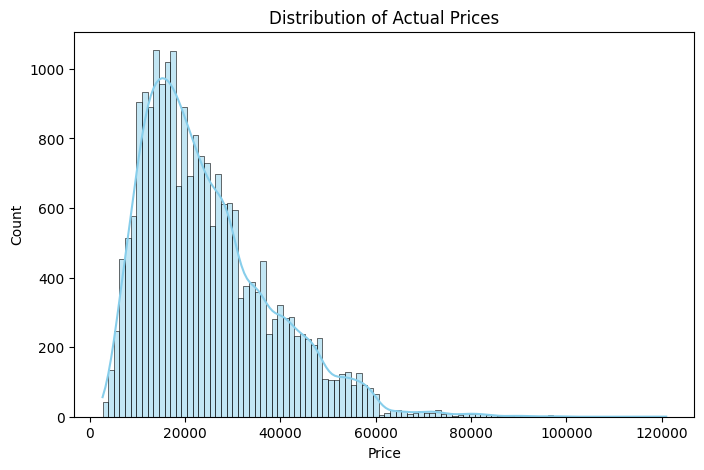

C:\Users\jaxon\AppData\Local\Temp\ipykernel_17624\3644942150.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.array(features_cb)[indices], y=importances[indices], palette='viridis')


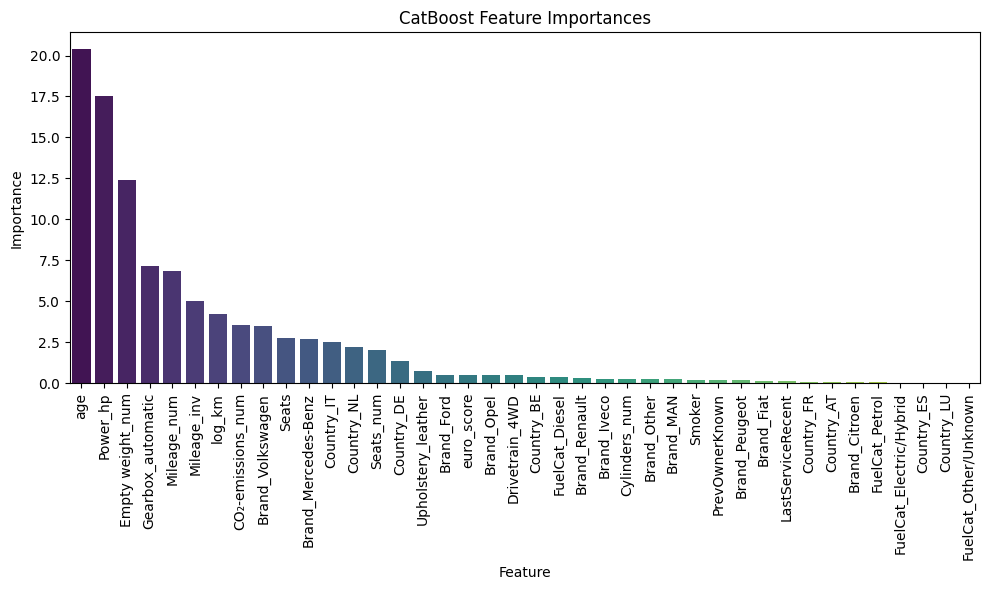

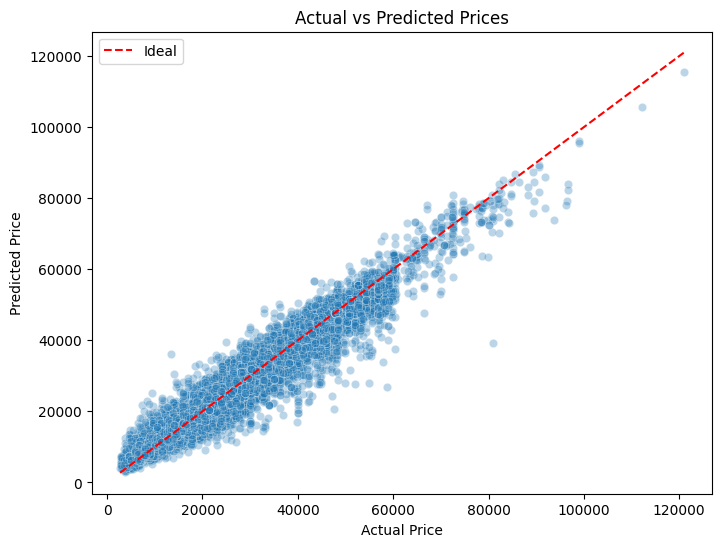

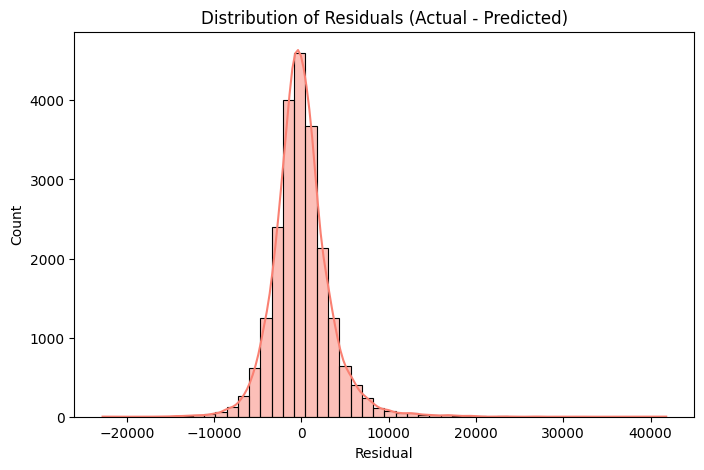

In [34]:
# Visualizations for CatBoost model performance and data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Price distribution
plt.figure(figsize=(8,5))
sns.histplot(y_cb, bins=100, kde=True, color='skyblue')
plt.title('Distribution of Actual Prices')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

# 2. Feature importances
importances = model_cb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
sns.barplot(x=np.array(features_cb)[indices], y=importances[indices], palette='viridis')
plt.xticks(rotation=90)
plt.title('CatBoost Feature Importances')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# 3. Actual vs Predicted Prices
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_cb, y=y_pred_cb, alpha=0.3)
plt.plot([y_cb.min(), y_cb.max()], [y_cb.min(), y_cb.max()], 'r--', label='Ideal')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()

# 4. Residuals distribution
residuals = y_cb - y_pred_cb
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color='salmon')
plt.title('Distribution of Residuals (Actual - Predicted)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()